In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Set Seaborn style for better visuals
sns.set_style('darkgrid')
%matplotlib inline

Load All the Dataset

In [9]:
file_path_benin = '../data/benin-malanville.csv'
file_path_sierraleone = '../data/sierraleone-bumbuna.csv'
file_path_togo = '../data/togo-dapaong_qc.csv'
benin_df = pd.read_csv(file_path_benin)
sierra_leone_df = pd.read_csv(file_path_sierraleone)
togo_df = pd.read_csv(file_path_togo)

Add 'Country' column

In [10]:
benin_df['Country'] = 'Benin'
sierra_leone_df['Country'] = 'Sierra Leone'
togo_df['Country'] = 'Togo'

Combine into a single DataFrame

In [11]:
df_combined = pd.concat([benin_df, sierra_leone_df, togo_df], ignore_index=True)

Convert Timestamp to datetime

In [12]:
df_combined['Timestamp'] = pd.to_datetime(df_combined['Timestamp'])

Initial inspection

In [13]:
print("Combined DataFrame Shape:", df_combined.shape)
print("Columns:", df_combined.columns.tolist())
print("\nMissing Values:")
print(df_combined.isna().sum())
df_combined.head()

Combined DataFrame Shape: (1576800, 20)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Country']

Missing Values:
Timestamp              0
GHI                    0
DNI                    0
DHI                    0
ModA                   0
ModB                   0
Tamb                   0
RH                     0
WS                     0
WSgust                 0
WSstdev                0
WD                     0
WDstdev                0
BP                     0
Cleaning               0
Precipitation          0
TModA                  0
TModB                  0
Comments         1576800
Country                0
dtype: int64


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,Benin


In [15]:
# Identify columns with missing values
missing_percent = df_combined.isna().mean() * 100
columns_to_clean = missing_percent[missing_percent > 0].index
print("Columns with missing values and percentage:")
print(missing_percent[missing_percent > 0])

# Impute missing values with median for key columns
key_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'ModA', 'ModB', 'WS', 'WSgust']
for column in key_columns:
    if column in df_combined.columns:
        df_combined[column].fillna(df_combined[column].median(), inplace=True)

# Verify no missing values
print("\nMissing Values After Imputation:")
print(df_combined[key_columns].isna().sum())

Columns with missing values and percentage:
Comments    100.0
dtype: float64

Missing Values After Imputation:
GHI       0
DNI       0
DHI       0
Tamb      0
RH        0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


In [16]:
# Compute Z-scores for key columns
z_scores = np.abs(stats.zscore(df_combined[key_columns], nan_policy='omit'))
outlier_mask = (z_scores > 3).any(axis=1)

# Count and inspect outliers
print(f"Number of outlier rows: {outlier_mask.sum()}")
print("\nSample of outlier rows:")
print(df_combined[outlier_mask].head())

# Cap outliers at 99th percentile
for column in key_columns:
    if column in df_combined.columns:
        upper_limit = df_combined[column].quantile(0.99)
        df_combined.loc[df_combined[column] > upper_limit, column] = upper_limit

# Verify outlier reduction
z_scores_new = np.abs(stats.zscore(df_combined[key_columns], nan_policy='omit'))
print(f"\nNumber of rows with |Z| > 3 after capping: {(z_scores_new > 3).any(axis=1).sum()}")

Number of outlier rows: 29060

Sample of outlier rows:
              Timestamp     GHI    DNI    DHI    ModA    ModB  Tamb    RH  \
670 2021-08-09 11:11:00   836.0  235.0  610.6   778.8   783.8  30.3  68.2   
671 2021-08-09 11:12:00  1274.0  698.8  615.2  1210.3  1210.3  30.1  69.6   
672 2021-08-09 11:13:00   938.0  340.1  612.8   891.1   891.1  30.4  68.4   
673 2021-08-09 11:14:00   718.5  126.8  593.2   682.6   682.6  30.6  68.2   
674 2021-08-09 11:15:00  1349.0  771.8  618.0  1281.5  1281.5  30.9  67.1   

      WS  WSgust  WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  \
670  3.2     4.1      0.7  190.5     18.4  999         0            0.0   
671  3.4     4.1      0.6  175.8     13.3  999         0            0.0   
672  3.4     4.6      0.9  171.5     11.9  999         0            0.0   
673  4.7     5.6      0.6  160.7      8.0  999         0            0.0   
674  4.0     4.6      0.4  169.1     12.3  999         0            0.0   

     TModA  TModB  Comments Cou

In [17]:
# Check for duplicates
duplicates = df_combined.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates
df_combined = df_combined.drop_duplicates()
print("DataFrame Shape after removing duplicates:", df_combined.shape)

Number of duplicate rows: 0
DataFrame Shape after removing duplicates: (1576800, 20)


In [18]:
# Check data types
print("\nData Types:")
print(df_combined.dtypes)

# Ensure numeric columns are float
for column in key_columns:
    if column in df_combined.columns and df_combined[column].dtype != 'float64':
        df_combined[column] = df_combined[column].astype('float64')

# Verify
print("\nUpdated Data Types:")
print(df_combined.dtypes)


Data Types:
Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  float64
WSstdev                 float64
WD                      float64
WDstdev                 float64
BP                        int64
Cleaning                  int64
Precipitation           float64
TModA                   float64
TModB                   float64
Comments                float64
Country                  object
dtype: object

Updated Data Types:
Timestamp        datetime64[ns]
GHI                     float64
DNI                     float64
DHI                     float64
ModA                    float64
ModB                    float64
Tamb                    float64
RH                      float64
WS                      float64
WSgust                  

In [20]:
# Export cleaned combined dataset
cleaned_file_path = '../data/combined_clean.csv'
df_combined.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data exported to {cleaned_file_path}")

Cleaned data exported to ../data/combined_clean.csv


In [21]:
# Quick validation
print("\nFinal Missing Values:")
print(df_combined[key_columns].isna().sum())
print("Final Shape:", df_combined.shape)
df_combined.describe()


Final Missing Values:
GHI       0
DNI       0
DHI       0
Tamb      0
RH        0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64
Final Shape: (1576800, 20)


,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
count,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,1.576800e+06,0.0
mean,2.235989e+02,1.445938e+02,1.147231e+02,2.225424e+02,2.149174e+02,2.740639e+01,6.298333e+01,1.866993e+00,2.560066e+00,4.649840e-01,1.494072e+02,8.771398e+00,9.899963e+02,8.079655e-04,2.697615e-03,3.339823e+01,3.286939e+01,NaN
std,3.160690e+02,2.443589e+02,1.566620e+02,3.139291e+02,3.033168e+02,5.104511e+00,2.854366e+01,1.493930e+00,1.898550e+00,2.904002e-01,1.039399e+02,6.790689e+00,1.046797e+01,2.841326e-02,3.803610e-02,1.290953e+01,1.238889e+01,NaN
min,-1.950000e+01,-7.800000e+00,-1.790000e+01,0.000000e+00,0.000000e+00,1.100000e+01,2.100000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.680000e+02,0.000000e+00,0.000000e+00,9.000000e+00,8.100000e+00,NaN
25%,-2.200000e+00,-2.000000e-01,-1.400000e+00,0.000000e+00,0.000000e+00,2.370000e+01,3.860000e+01,6.000000e-01,1.100000e+00,4.000000e-01,5.330000e+01,2.900000e+00,9.770000e+02,0.000000e+00,0.000000e+00,2.370000e+01,2.370000e+01,NaN
50%,1.200000e+00,0.000000e+00,1.400000e+00,4.100000e+00,4.000000e+00,2.680000e+01,6.900000e+01,1.800000e+00,2.400000e+00,5.000000e-01,1.803000e+02,9.000000e+00,9.940000e+02,0.000000e+00,0.000000e+00,2.830000e+01,2.800000e+01,NaN
75%,4.244000e+02,2.270000e+02,2.190000e+02,4.111000e+02,3.973000e+02,3.100000e+01,8.860000e+01,2.800000e+00,3.600000e+00,6.000000e-01,2.342000e+02,1.290000e+01,9.990000e+02,0.000000e+00,0.000000e+00,4.260000e+01,4.190000e+01,NaN
max,1.006000e+03,8.360000e+02,5.650000e+02,9.922000e+02,9.700000e+02,3.940000e+01,1.000000e+02,6.100000e+00,7.900000e+00,4.700000e+00,3.600000e+02,9.940000e+01,1.006000e+03,1.000000e+00,2.500000e+00,8.100000e+01,9.460000e+01,NaN


In [22]:
# Verify cleaned dataset
print("Final Shape:", df_combined.shape)
print("Columns:", df_combined.columns.tolist())
print("Missing Values:")
print(df_combined[['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'ModA', 'ModB', 'WS', 'WSgust']].isna().sum())
df_combined.head()

Final Shape: (1576800, 20)
Columns: ['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments', 'Country']
Missing Values:
GHI       0
DNI       0
DHI       0
Tamb      0
RH        0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,Benin


C:\Users\hp\AppData\Local\Temp\ipykernel_17696\1373322825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country', y=metric, data=df_combined, palette='Set3')
C:\Users\hp\AppData\Local\Temp\ipykernel_17696\1373322825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country', y=metric, data=df_combined, palette='Set3')
C:\Users\hp\AppData\Local\Temp\ipykernel_17696\1373322825.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Country', y=metric, data=df_combined, palette='Set3')


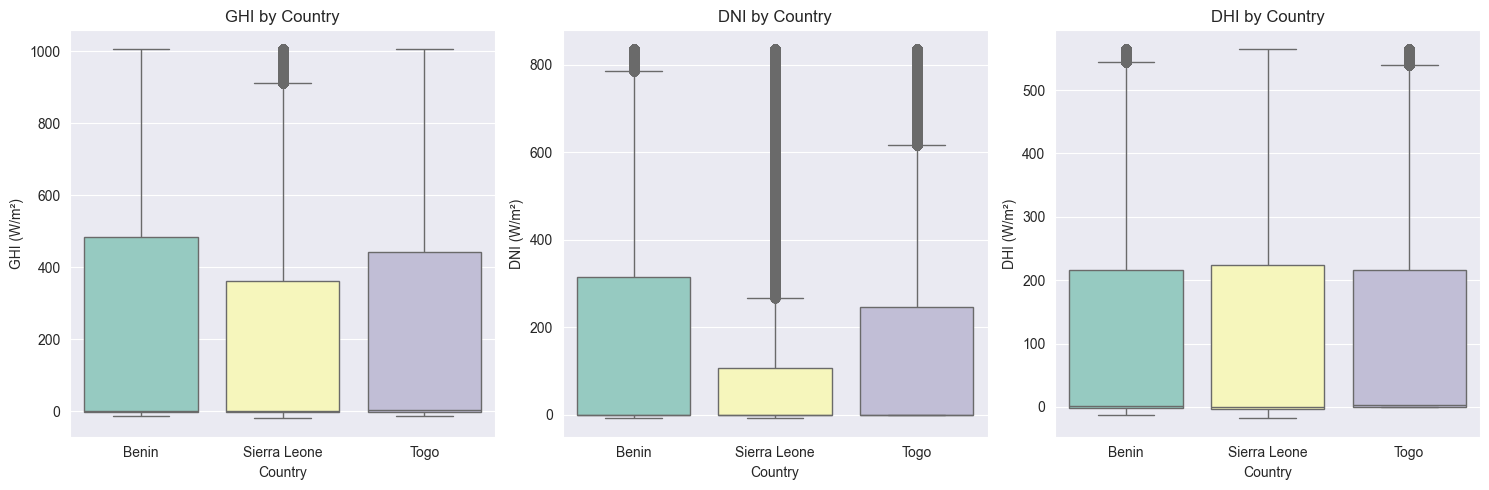

In [23]:
# Boxplots for GHI, DNI, DHI
metrics = ['GHI', 'DNI', 'DHI']

plt.figure(figsize=(15, 5))
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Country', y=metric, data=df_combined, palette='Set3')
    plt.title(f'{metric} by Country')
    plt.xlabel('Country')
    plt.ylabel(f'{metric} (W/m²)')
plt.tight_layout()
plt.show()

In [24]:
# Summary table: mean, median, std for GHI, DNI, DHI
summary_stats = df_combined.groupby('Country')[['GHI', 'DNI', 'DHI']].agg(['mean', 'median', 'std']).round(2)

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns.values]
print("Summary Statistics Table:")
print(summary_stats)

Summary Statistics Table:
              GHI_mean  GHI_median  GHI_std  DNI_mean  DNI_median  DNI_std  \
Country                                                                      
Benin           240.06         1.8   329.87    166.77        -0.1   260.60   
Sierra Leone    200.89         0.3   295.33    116.24        -0.1   218.17   
Togo            229.85         2.1   320.69    150.78         0.0   249.58   

              DHI_mean  DHI_median  DHI_std  
Country                                      
Benin           114.86         1.6   157.15  
Sierra Leone    113.28        -0.1   157.58  
Togo            116.03         2.5   155.24  


In [25]:
# Prepare data for testing
ghi_by_country = [df_combined[df_combined['Country'] == country]['GHI'].dropna() for country in df_combined['Country'].unique()]

# Normality test (Shapiro-Wilk)
print("Normality Test (Shapiro-Wilk):")
for country in df_combined['Country'].unique():
    ghi_values = df_combined[df_combined['Country'] == country]['GHI'].dropna()
    stat, p = stats.shapiro(ghi_values)
    print(f"{country}: p-value = {p:.4f} {'(not normal)' if p < 0.05 else '(normal)'}")

# Homogeneity of variance (Levene's test)
stat, p = stats.levene(*ghi_by_country)
print(f"\nLevene's Test: p-value = {p:.4f} {'(unequal variances)' if p < 0.05 else '(equal variances)'}")

# Run appropriate test
use_kruskal = False
if p < 0.05 or any(stats.shapiro(g)[1] < 0.05 for g in ghi_by_country):
    use_kruskal = True

if use_kruskal:
    stat, p = stats.kruskal(*ghi_by_country)
    print("\nKruskal-Wallis Test for GHI:")
else:
    stat, p = stats.f_oneway(*ghi_by_country)
    print("\nOne-Way ANOVA for GHI:")

print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p < 0.05:
    print("Significant difference in GHI means across countries (p < 0.05)")
else:
    print("No significant difference in GHI means across countries (p >= 0.05)")

Normality Test (Shapiro-Wilk):


c:\Users\hp\Documents\10 Acadamy weekly project\solar-challenge-week1\venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 525600.
  res = hypotest_fun_out(*samples, **kwds)


Benin: p-value = 0.0000 (not normal)
Sierra Leone: p-value = 0.0000 (not normal)
Togo: p-value = 0.0000 (not normal)

Levene's Test: p-value = 0.0000 (unequal variances)

Kruskal-Wallis Test for GHI:
Statistic = 4527.8701, p-value = 0.0000
Significant difference in GHI means across countries (p < 0.05)


C:\Users\hp\AppData\Local\Temp\ipykernel_17696\781399002.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_ghi.values, y=avg_ghi.index, palette='viridis')


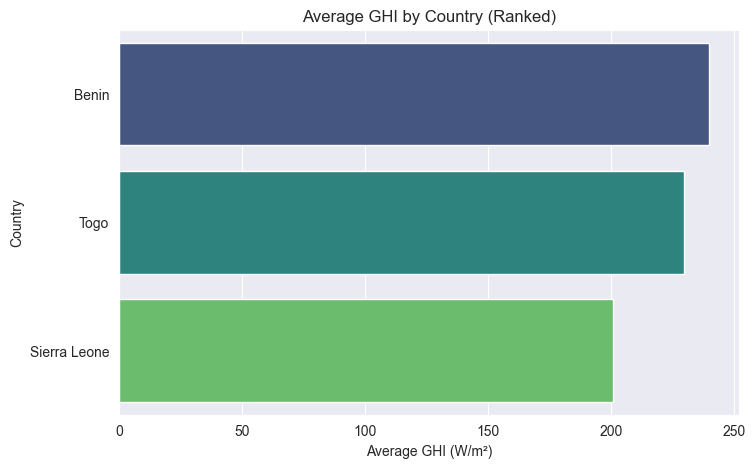

In [26]:
# Bar chart of average GHI by country
avg_ghi = df_combined.groupby('Country')['GHI'].mean().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_ghi.values, y=avg_ghi.index, palette='viridis')
plt.title('Average GHI by Country (Ranked)')
plt.xlabel('Average GHI (W/m²)')
plt.ylabel('Country')
plt.show()